<a href="https://colab.research.google.com/github/GuangyuHan/Projects/blob/main/Barin_Tumor_Images_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.applications import MobileNet, MobileNetV2, VGG16
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Dense, BatchNormalization
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout



**Checking Folders and Files**



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Northeastern/IE 7615/Final Project/"
list(os.listdir(path))

['Testing', 'Training']

In [4]:
list(os.listdir(path + 'Training'))

['no_tumor', 'meningioma_tumor', 'pituitary_tumor', 'glioma_tumor']

In [5]:
list(os.listdir(path + 'Testing'))

['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']

In [6]:
Images = []
Labels = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

image_size = 224

for i in labels:
  folderPath = os.path.join(path, 'Training', i)
  for j in tqdm(os.listdir(folderPath)):
    # The tqdm function takes an iterable as an argument, and returns an iterator that you can loop over.
    # As you loop over it, it updates the progress bar.
    img = cv2.imread(os.path.join(folderPath, j))
    img = cv2.resize(img,(image_size, image_size)) #Resizing the image
    img = img.astype(np.float32)/255 # Normalize the image
    Images.append(img)
    Labels.append(i)

for i in labels:
  folderPath = os.path.join(path, 'Testing', i )
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath, j))
    img = cv2.resize(img, (image_size, image_size)) #Resizing the image
    img = img.astype(np.float32)/255 # Normalize the image
    Images.append(img)
    Labels.append(i)

X = np.array(Images)
y = np.array(Labels)

100%|██████████| 74/74 [00:26<00:00,  2.81it/s]



So by the end of this process, there will be two lists: Images, which contains all the processed images from all directories, and Labels, which contains the corresponding labels for each image. The labels in the Labels list are strings, with the same value as the name of the directory the image came from.

In [7]:
# Shuffling the data
X_train, y_train = shuffle(X, y, random_state=42)

# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=100)

# convert y_train to numerical values and then One Hot Encoding
y_train_new=[]

for i in y_train:
    y_train_new.append(labels.index(i))

y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train, dtype="uint8")

y_test_new=[]

for i in y_test:
    y_test_new.append(labels.index(i))

y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test, dtype="uint8")



In [8]:
#Apply augmentation to the training data
datagen = ImageDataGenerator(
    rotation_range = 7,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.1,
    horizontal_flip=True
)
datagen.fit(X)
X_train.shape

(3052, 224, 224, 3)

**Visualization**

We randomly pick one image from each category

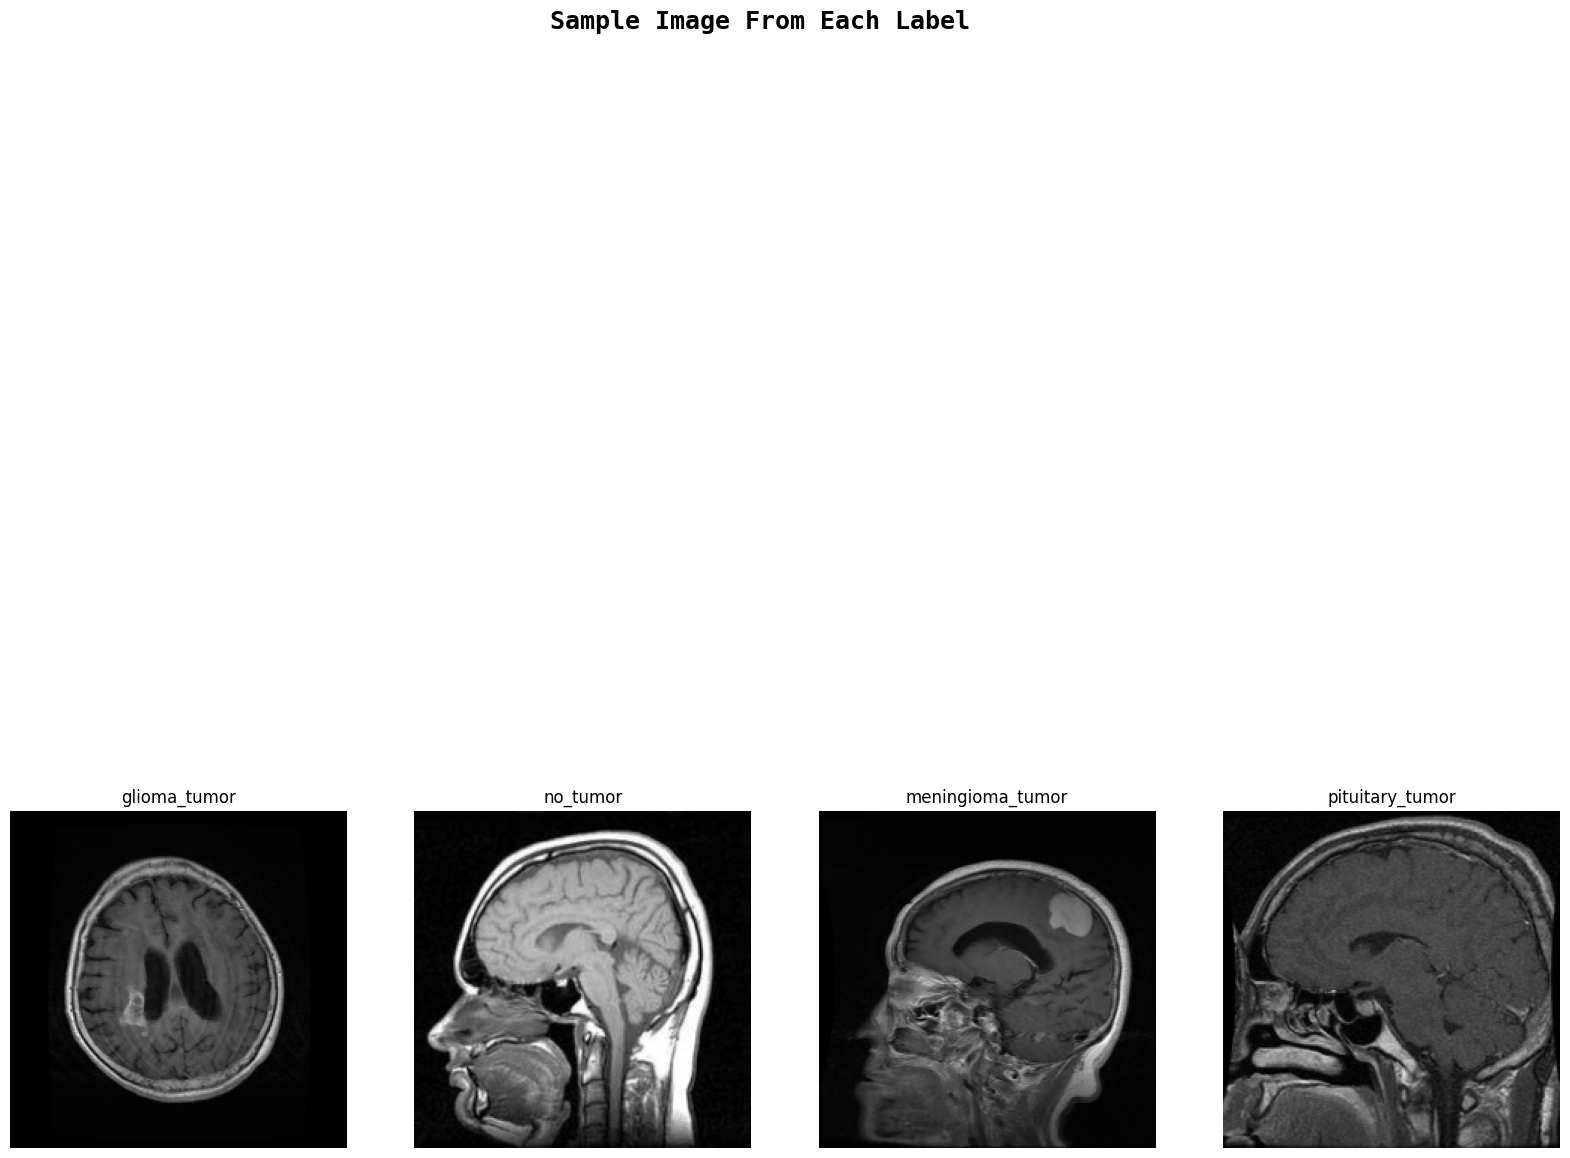

In [9]:
import matplotlib.pyplot as plt

sample_images = {label: None for label in labels}

for img, label in zip(X, y):
    if sample_images[label] is None:
        sample_images[label] = img

num_samples = len(labels)
fig, ax = plt.subplots(1, num_samples, figsize=(20, 20))
fig.suptitle('Sample Image From Each Label', size=18, fontweight='bold', fontname='monospace')

for index, (label, sample_image) in enumerate(sample_images.items()):
    if sample_image is not None:
        sample_image = sample_image * 255 # Rescale the Pixel values to range [0, 255]
        sample_image = sample_image.astype(np.uint8)  # Ensure the image data type is np.uint8
        ax[index].imshow(sample_image)
        ax[index].set_title(label)
        ax[index].axis('off')
    else:
        print(f"No sample image found for label: {label}")

plt.show()



**Define VGG16(CNN) Models**


In [10]:
from keras.layers import GlobalAveragePooling2D

model1 = Sequential()
model1.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model1.add(GlobalAveragePooling2D())  # Add GlobalAveragePooling2D layer

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.7))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation='softmax'))

# Compile CNN model
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994
)
model1.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


In [11]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [12]:
# Model Fit
hist = model1.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split=0.1, verbose=1)

Epoch 1/50
86/86 [==============================] - 25s 99ms/step - loss: 1.3793 - accuracy: 0.3012 - val_loss: 1.3804 - val_accuracy: 0.2778
Epoch 2/50
86/86 [==============================] - 5s 54ms/step - loss: 1.3687 - accuracy: 0.3092 - val_loss: 1.3766 - val_accuracy: 0.2778
Epoch 3/50
86/86 [==============================] - 5s 54ms/step - loss: 1.3670 - accuracy: 0.3150 - val_loss: 1.3734 - val_accuracy: 0.2778
Epoch 4/50
86/86 [==============================] - 5s 54ms/step - loss: 1.3411 - accuracy: 0.3270 - val_loss: 1.2848 - val_accuracy: 0.2778
Epoch 5/50
86/86 [==============================] - 5s 54ms/step - loss: 1.2616 - accuracy: 0.4104 - val_loss: 1.1849 - val_accuracy: 0.4216
Epoch 6/50
86/86 [==============================] - 5s 55ms/step - loss: 1.1953 - accuracy: 0.4250 - val_loss: 1.1364 - val_accuracy: 0.3954
Epoch 7/50
86/86 [==============================] - 5s 54ms/step - loss: 1.1717 - accuracy: 0.4213 - val_loss: 1.1278 - val_accuracy: 0.3954
Epoch 8/50
8

**Evaluate the traing performance**

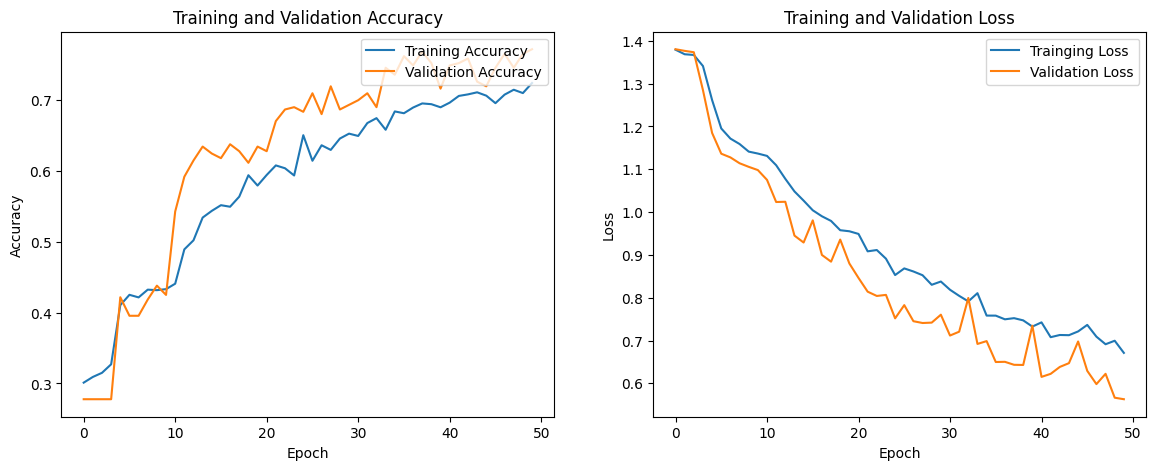

In [13]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(len(hist.history['accuracy']))

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(range(len(hist.history['accuracy'])), acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Trainging Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


**Prediction**


In [14]:
loss,accuracy = model1.evaluate(X_test, y_test)

11/11 [==============================] - 1s 79ms/step - loss: 0.6222 - accuracy: 0.7471


I've used the argmax function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with arg, max I'm able to find out the index associated with the predicted outcome

In [15]:
pred = model1.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

11/11 [==============================] - 0s 20ms/step


**Classification Report & Confusion Matrix Evaluation**

In this,

0 - Glioma Tumor

1 - No Tumor

2 - Meningioma Tumor

3 - Pituitary Tumor

In [16]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.90      0.61      0.73       103
           1       0.60      0.72      0.65        47
           2       0.63      0.72      0.67       100
           3       0.87      0.94      0.90        90

    accuracy                           0.75       340
   macro avg       0.75      0.75      0.74       340
weighted avg       0.77      0.75      0.75       340



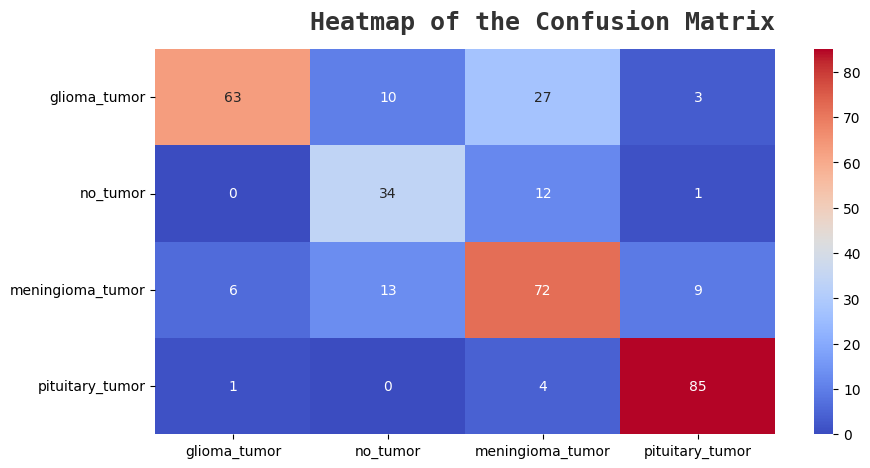

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True, cmap='coolwarm')
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold', fontname='monospace', y=0.92, x=0.28, alpha=0.8)
plt.show()


**Apply Machine Learning models**

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score


Images = []
Labels = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

image_size = 224

for i in labels:
  folderPath = os.path.join(path, 'Training', i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath, j))
    img = cv2.resize(img,(image_size, image_size))
    img = img.astype(np.float32)/255 # Normalize the image
    Images.append(img)
    Labels.append(labels.index(i)) # Assign index of label instead of label

for i in labels:
  folderPath = os.path.join(path, 'Testing', i )
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath, j))
    img = cv2.resize(img, (image_size, image_size))
    img = img.astype(np.float32)/255 # Normalize the image
    Images.append(img)
    Labels.append(labels.index(i)) # Assign index of label instead of label

X = np.array(Images)
y = np.array(Labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

# Reshape image in 1-dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)



100%|██████████| 74/74 [00:00<00:00, 136.40it/s]


**KNN**

Best K value is: 1 with error rate of: 0.05


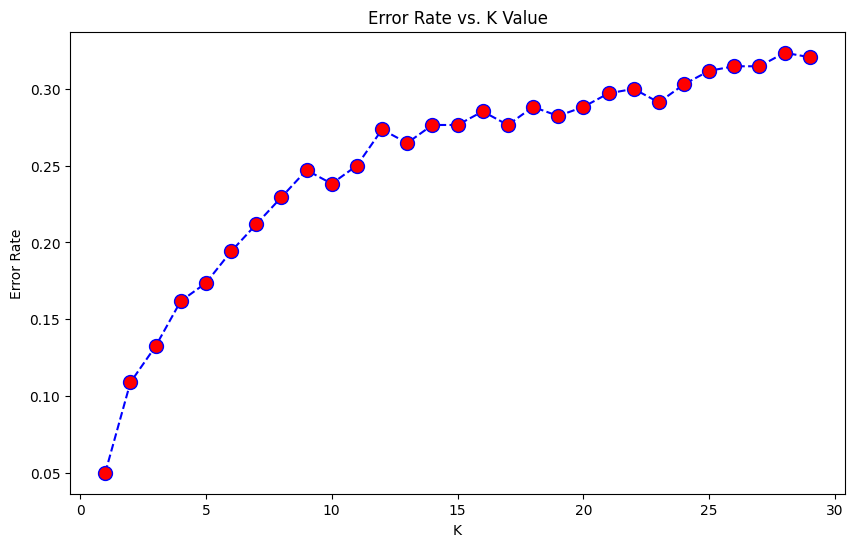

KNN accuracy: 0.95


In [20]:
error_rate = []
best_k = 1
lowest_error = 1

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_flat,y_train)
    pred_i = knn.predict(X_test_flat)
    error = np.mean(pred_i != y_test)
    error_rate.append(error)

    if error < lowest_error:
        best_k = i
        lowest_error = error

print(f"Best K value is: {best_k} with error rate of: {lowest_error}")

plt.figure(figsize=(10,6))
plt.plot(range(1, 30),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

# Build the model with the best K
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_flat, y_train)
knn_predictions = knn.predict(X_test_flat)
print('KNN accuracy:', accuracy_score(y_test, knn_predictions))


This means that the model is classifying a new data point based on the closest single data point in the training dataset. However, a k value of 1 could potentially make the model highly sensitive to noise in the training data.



In [ ]:
# Create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=best_k)

# Train model with 5-fold cv
cv_scores = cross_val_score(knn_cv, X_train_flat, y_train, cv=5)

print(cv_scores)
print(f'cv_scores mean: {np.mean(cv_scores)}')




In this code, I intended to train and validate the model for 5 different splits of the original data (specified by cv=5), then printing the accuracy score for each split as well as the average across all 5 splits.

However, since CV is computationally expensive, I fail to finish the running codes.


In [21]:
# Print confusion matrix
print('Confusion Matrix for KNN:')
print(confusion_matrix(y_test, knn_predictions))
# Print classification report
print('Classification Report for KNN:')
print(classification_report(y_test, knn_predictions))

Confusion Matrix for KNN:
[[97  2  5  1]
 [ 3 44  0  2]
 [ 3  0 93  1]
 [ 0  0  0 89]]
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       105
           1       0.96      0.90      0.93        49
           2       0.95      0.96      0.95        97
           3       0.96      1.00      0.98        89

    accuracy                           0.95       340
   macro avg       0.95      0.95      0.95       340
weighted avg       0.95      0.95      0.95       340



**CART**

In [ ]:
cart = DecisionTreeClassifier()
cart.fit(X_train_flat, y_train)
cart_predictions = cart.predict(X_test_flat)
print('CART accuracy:', accuracy_score(y_test, cart_predictions))

CART accuracy: 0.8058823529411765


In [ ]:
# Fit a decision tree classifier to the training data
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train_flat, y_train)

# Compute the optimal value for the pruning parameter 'ccp_alpha'
path = tree.cost_complexity_pruning_path(X_train_flat, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
ccp_alphas

array([0.        , 0.00032548, 0.00032765, 0.00032765, 0.00032765,
       0.00032765, 0.00032765, 0.00032765, 0.00032765, 0.00032765,
       0.00032765, 0.00032765, 0.00043687, 0.00043687, 0.00043687,
       0.00043687, 0.00043687, 0.00043687, 0.00043687, 0.00049148,
       0.00049148, 0.00049148, 0.00049148, 0.00049148, 0.00049148,
       0.00049148, 0.00049148, 0.00049148, 0.00052425, 0.00052425,
       0.00052425, 0.00054609, 0.00054609, 0.00054609, 0.00056169,
       0.00056169, 0.00056169, 0.0005825 , 0.0005825 , 0.0006007 ,
       0.0006049 , 0.0006085 , 0.00062082, 0.0006241 , 0.0006241 ,
       0.00063271, 0.0006422 , 0.00064277, 0.00064507, 0.00064671,
       0.00064712, 0.00064794, 0.00065031, 0.00065257, 0.00065531,
       0.00076453, 0.00077233, 0.00078637, 0.00078637, 0.00086512,
       0.00091275, 0.0009237 , 0.00093615, 0.00094201, 0.00094441,
       0.00094483, 0.00095125, 0.00095566, 0.00095566, 0.00096374,
       0.00097131, 0.00098296, 0.00098296, 0.00104849, 0.00107

In [ ]:
# Train a decision tree classifier for each 'ccp_alpha' and evaluate its performance using cross-validation
trees = []
# For example, we only use every 10th 'ccp_alpha' for model training
for i in range(0, len(ccp_alphas), 15):
    ccp_alpha = ccp_alphas[i]
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(tree, X_train_flat, y_train, cv=5)
    trees.append((ccp_alpha, scores.mean()))

# Choose the 'ccp_alpha' with the highest cross-validated accuracy
best_ccp_alpha, best_score = max(trees, key=lambda x: x[1])

# Train the final decision tree classifier using the best 'ccp_alpha'
tree = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha)
tree.fit(X_train_flat, y_train)

# Plot the accuracy as a function of 'ccp_alpha'
plt.plot([x[0] for x in trees], [x[1] for x in trees], marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Cross-validated accuracy')
plt.show()


In [22]:
cart = DecisionTreeClassifier(random_state=0, ccp_alpha=0.001)
cart.fit(X_train_flat, y_train)
cart_predictions = cart.predict(X_test_flat)
print('CART accuracy:', accuracy_score(y_test, cart_predictions))

CART accuracy: 0.8029411764705883


In [23]:
# Print confusion matrix
print('Confusion Matrix for CART:')
print(confusion_matrix(y_test, cart_predictions))
# Print classification report
print('Classification Report for CART:')
print(classification_report(y_test, cart_predictions))

Confusion Matrix for CART:
[[88  1 13  3]
 [ 3 38  7  1]
 [14  3 75  5]
 [ 9  3  5 72]]
Classification Report for CART:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       105
           1       0.84      0.78      0.81        49
           2       0.75      0.77      0.76        97
           3       0.89      0.81      0.85        89

    accuracy                           0.80       340
   macro avg       0.81      0.80      0.81       340
weighted avg       0.81      0.80      0.80       340



**Random Forest**

In [ ]:
# Define the parameter distribution
param_dist = {
    'n_estimators': randint(low=100, high=400),
    'max_depth': [None] + list(randint(low=10, high=30).rvs(size=3)),
    'min_samples_split': randint(low=2, high=10),
    'min_samples_leaf': randint(low=1, high=4),
    'max_features': ['auto', 'sqrt']
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the random search model
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train_flat, y_train)

# Get the best parameters
best_params = random_search.best_params_

print(f"Best parameters: {best_params}")

# Get the best estimator
best_rf = random_search.best_estimator_

# Predict the test set results
rf_predictions = best_rf.predict(X_test_flat)

# Calculate the accuracy of the model
print('Random Forest accuracy:', accuracy_score(y_test, rf_predictions))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


In the codes above, I tried to fit a randomo forest model with optimal parameter found by random search. However, it was too computational expensive for my device to run it.

So, in the codes below, I fit a random forest base model:

In [24]:
# Random Forest Base Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)
rf_predictions = rf.predict(X_test_flat)
print('Random Forest accuracy:', accuracy_score(y_test, rf_predictions))

Random Forest accuracy: 0.9176470588235294


In [25]:
# Print confusion matrix
print('Confusion Matrix for :')
print(confusion_matrix(y_test, rf_predictions))
# Print classification report
print('Classification Report for :')
print(classification_report(y_test, rf_predictions))

Confusion Matrix for :
[[88  3 13  1]
 [ 0 48  1  0]
 [ 1  1 92  3]
 [ 1  0  4 84]]
Classification Report for :
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       105
           1       0.92      0.98      0.95        49
           2       0.84      0.95      0.89        97
           3       0.95      0.94      0.95        89

    accuracy                           0.92       340
   macro avg       0.92      0.93      0.92       340
weighted avg       0.92      0.92      0.92       340



In [26]:
model_accuracy = {
    'KNN': accuracy_score(y_test, knn_predictions),
    'CART': accuracy_score(y_test, cart_predictions),
    'Random Forest': accuracy_score(y_test, rf_predictions),
    'CNN': accuracy
}

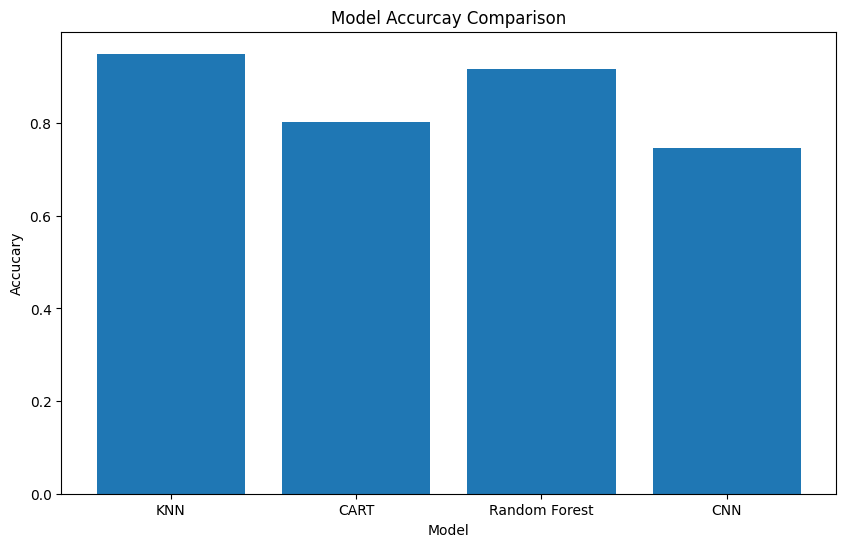

In [27]:
plt.figure(figsize=(10, 6))
plt.bar(model_accuracy.keys(), model_accuracy.values())
plt.xlabel('Model')
plt.ylabel('Accucary')
plt.title('Model Accurcay Comparison')
plt.show()